In [1]:
from sympy import *
init_printing()

In [ ]:
data_path_dmi = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/dmi_weather_data.csv'
data_path_vandstand = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandstand (DMP)_Time.csv'

In [11]:
import pandas as pd

# Fil­sti­er
data_path_dmi = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/dmi_weather_data.csv'
data_path_vandstand = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandstand (DMP)_Time.csv'

# 1) Ind­læs DMI-data med MultiIndex-kolonner
df_dmi = pd.read_csv(
    data_path_dmi,
    header=[0, 1],        # to header-rækker: stationId og parameterId
    index_col=0,          # første kolonne er tid
    parse_dates=True,
    encoding='latin1',
    engine='python'
)
# Lokalizér / konvertér tidszone
if df_dmi.index.tz is None:
    df_dmi.index = df_dmi.index.tz_localize('UTC')
df_dmi.index = df_dmi.index.tz_convert('Europe/Copenhagen')

# 1b) Flatten DMI-kolonnerne til enkelt niveau
df_dmi.columns = [
    f"{station.strip()}_{param.strip()}"
    for station, param in df_dmi.columns
]

# 2) Find header-linjen i vandstandsfilen
with open(data_path_vandstand, encoding='latin1') as f:
    for i, line in enumerate(f):
        if line.strip().startswith('Dato (DK normaltid)'):
            header_row = i
            break

# 3) Ind­læs vandstand (spring metadata + header-linje)
df_vand = pd.read_csv(
    data_path_vandstand,
    sep=';',
    skiprows=header_row,
    header=0,
    parse_dates=[0],
    dayfirst=True,
    encoding='latin1',
    engine='python'
)
df_vand.rename(columns={
    'Dato (DK normaltid)':       'datetime',
    'Vandstand (DMP) (m DVR90)': 'water_level',
    'ks mrk.':                   'quality_flag'
}, inplace=True)
df_vand.set_index('datetime', inplace=True)

# 3b) Lokaliser til dansk tid, håndter DST-skift
df_vand.index = pd.to_datetime(df_vand.index).tz_localize(
    'Europe/Copenhagen',
    ambiguous=False,        # vælg første (CET) ved tvetydige efterårs-tider
    nonexistent='shift_forward'
)

# 4) Afgræns til perioden 2002–01–01 til 2024–12–31
start = pd.Timestamp("2002-01-01 00:00:00", tz="Europe/Copenhagen")
end   = pd.Timestamp("2024-12-31 23:59:59", tz="Europe/Copenhagen")
df_dmi  = df_dmi.loc[start:end]
df_vand = df_vand.loc[start:end]

# 5) Flet dem sammen på indeks
df_merged = df_vand.join(df_dmi, how='inner')

# 6) Tjek resultatet
print("Merged indeks går fra", df_merged.index.min(), "til", df_merged.index.max())
df_merged.head()


Merged indeks går fra 2002-01-01 01:00:00+01:00 til 2024-12-31 01:00:00+01:00


,water_level,quality_flag,06102_temp_min_past1h,06102_temp_max_past1h,06102_temp_mean_past1h,06102_temp_grass_mean_past1h,06102_temp_soil_min_past1h,06102_temp_soil_max_past1h,06102_temp_soil_mean_past1h,06102_humidity_past1h,06102_pressure,06102_wind_dir_past1h,06102_wind_min_past1h,06102_wind_gust_always_past1h,06102_wind_speed_past1h,06102_precip_past1h,06102_precip_dur_past1h,06102_radia_glob_past1h,06102_sun_last1h_glob
2002-01-01 01:00:00+01:00,7.341,0,-4.4,-3.0,-3.5,-4.4,0.0,0.1,0.1,96.0,NaN,279.0,NaN,NaN,1.9,0.0,0.0,0.0,0.0
2002-01-01 02:00:00+01:00,7.337,0,-8.2,-4.4,-6.6,-7.7,0.0,0.1,0.1,94.0,NaN,281.0,NaN,NaN,2.2,0.0,0.0,0.0,0.0
2002-01-01 03:00:00+01:00,7.333,0,-8.9,-7.2,-7.9,-9.9,0.1,0.1,0.1,94.0,NaN,280.0,NaN,NaN,2.2,0.0,0.0,0.0,0.0
2002-01-01 04:00:00+01:00,7.332,0,-9.3,-7.9,-8.4,-10.7,0.0,0.1,0.1,93.0,NaN,276.0,NaN,NaN,1.6,0.0,0.0,0.0,0.0
2002-01-01 05:00:00+01:00,7.332,0,-9.3,-7.2,-8.6,-10.3,0.0,0.1,0.1,93.0,NaN,276.0,NaN,NaN,2.1,0.0,0.0,0.0,0.0


In [13]:
# list of columns
columns = df_merged.columns.tolist()
columns

['water_level',
 'quality_flag',
 '06102_temp_min_past1h',
 '06102_temp_max_past1h',
 '06102_temp_mean_past1h',
 '06102_temp_grass_mean_past1h',
 '06102_temp_soil_min_past1h',
 '06102_temp_soil_max_past1h',
 '06102_temp_soil_mean_past1h',
 '06102_humidity_past1h',
 '06102_pressure',
 '06102_wind_dir_past1h',
 '06102_wind_min_past1h',
 '06102_wind_gust_always_past1h',
 '06102_wind_speed_past1h',
 '06102_precip_past1h',
 '06102_precip_dur_past1h',
 '06102_radia_glob_past1h',
 '06102_sun_last1h_glob']

In [14]:
# Create df of only water_level, temperature, and precipitation
simple_df = df_merged[['water_level', '06102_temp_mean_past1h', '06102_precip_past1h']]
simple_df.head()

,water_level,06102_temp_mean_past1h,06102_precip_past1h
2002-01-01 01:00:00+01:00,7.341,-3.5,0.0
2002-01-01 02:00:00+01:00,7.337,-6.6,0.0
2002-01-01 03:00:00+01:00,7.333,-7.9,0.0
2002-01-01 04:00:00+01:00,7.332,-8.4,0.0
2002-01-01 05:00:00+01:00,7.332,-8.6,0.0



Missing‐values per column:
                                missing_count  missing_pct
water_level                             8882     4.405732
quality_flag                               0     0.000000
06102_temp_min_past1h                   5995     2.973696
06102_temp_max_past1h                   5994     2.973200
06102_temp_mean_past1h                  5998     2.975184
06102_temp_grass_mean_past1h            6154     3.052564
06102_temp_soil_min_past1h              5535     2.745522
06102_temp_soil_max_past1h              5535     2.745522
06102_temp_soil_mean_past1h             5535     2.745522
06102_humidity_past1h                   6198     3.074390
06102_pressure                        151515    75.155877
06102_wind_dir_past1h                   5710     2.832327
06102_wind_min_past1h                 191281    94.880978
06102_wind_gust_always_past1h          20336    10.087252
06102_wind_speed_past1h                 5710     2.832327
06102_precip_past1h                     848

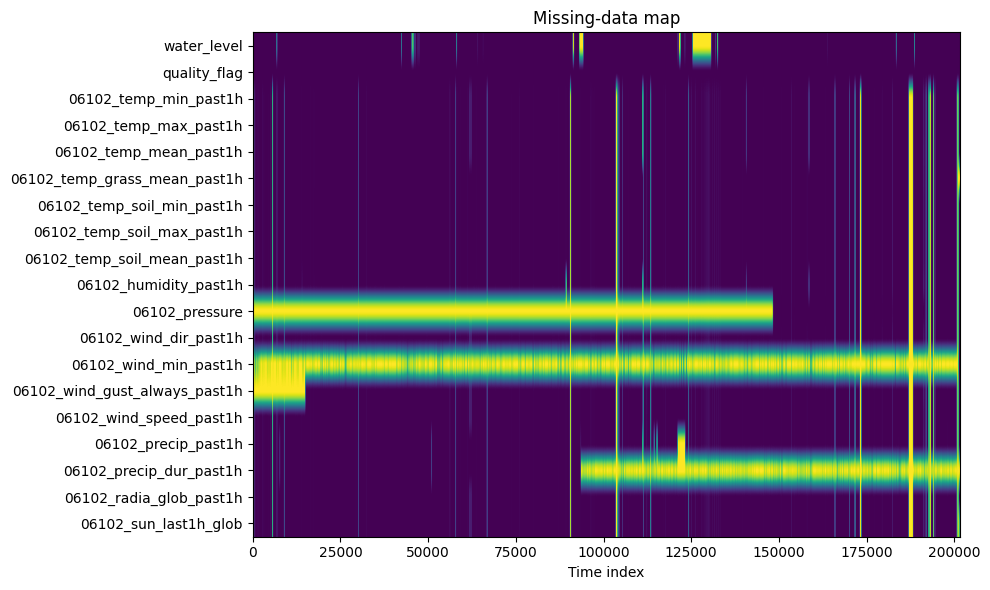

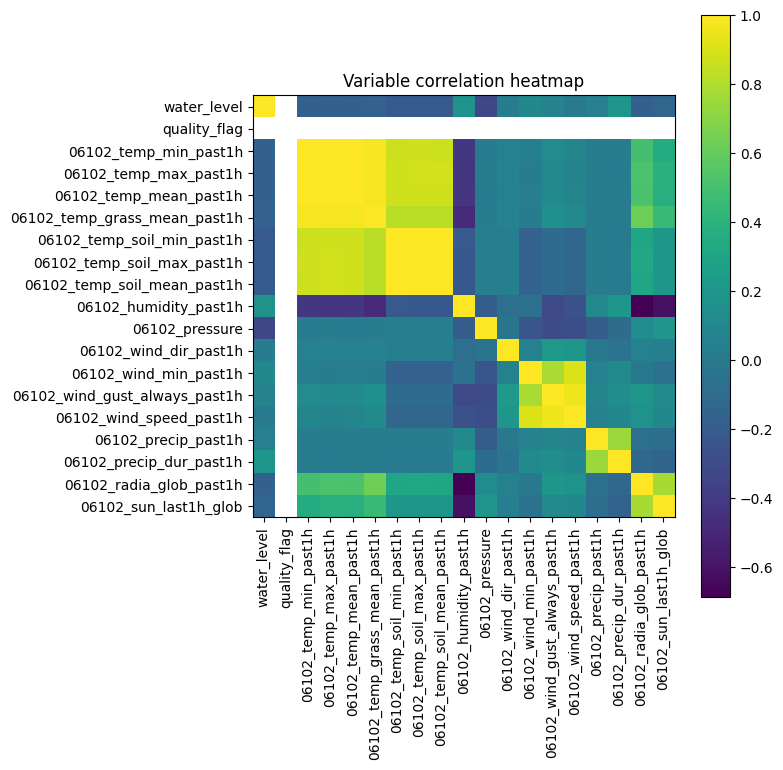


Lagged correlation:
     lag_hours  correlation
0           0     0.047948
1           1     0.053252
2           2     0.059213
3           3     0.065956
4           4     0.073046
5           5     0.079940
6           6     0.086076
7           7     0.091396
8           8     0.096078
9           9     0.099974
10         10     0.102976
11         11     0.104959
12         12     0.106003
13         13     0.106294
14         14     0.106114
15         15     0.105650
16         16     0.105001
17         17     0.104354
18         18     0.103619
19         19     0.102824
20         20     0.102132
21         21     0.101490
22         22     0.100853
23         23     0.100207
24         24     0.099472


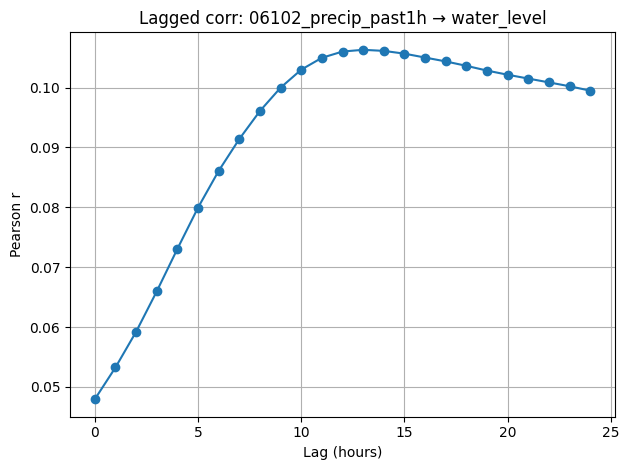

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1) Missing‐value summary
# -------------------------------------------------------------------
missing = df_merged.isna().sum().to_frame('missing_count')
missing['missing_pct'] = missing['missing_count'] / len(df_merged) * 100
print("\nMissing‐values per column:\n", missing)

# Visualize missing pattern as a heatmap (True=missing)
plt.figure(figsize=(10, 6))
plt.imshow(df_merged.isna().T, aspect='auto')
plt.yticks(range(len(df_merged.columns)), df_merged.columns)
plt.xlabel('Time index')
plt.title('Missing‐data map')
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 2) Correlation matrix
# -------------------------------------------------------------------
corr = df_merged.corr()

plt.figure(figsize=(8, 8))
plt.imshow(corr, aspect='equal')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title('Variable correlation heatmap')
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 3) Lagged correlation: precip_past1h vs. water_level
# -------------------------------------------------------------------
# adjust this if your precip‐column has a different name
precip_col = [c for c in df_merged.columns 
              if 'precip' in c.lower() and 'past1h' in c.lower()]
if not precip_col:
    raise KeyError("No column matching 'precip_past1h' found")
precip_col = precip_col[0]

lags = list(range(25))  # 0 … 24 hours
corrs = [
    df_merged['water_level'].corr(df_merged[precip_col].shift(lag))
    for lag in lags
]
lag_df = pd.DataFrame({'lag_hours': lags, 'correlation': corrs})
print("\nLagged correlation:\n", lag_df)

plt.figure()
plt.plot(lag_df['lag_hours'], lag_df['correlation'], marker='o')
plt.xlabel('Lag (hours)')
plt.ylabel('Pearson r')
plt.title(f'Lagged corr: {precip_col} → water_level')
plt.grid(True)
plt.tight_layout()
plt.show()


Missing-values for temp_mean_past1h og precip_past1h:
                         missing_count  missing_pct
06102_temp_mean_past1h           5998     2.975184
06102_precip_past1h              8483     4.207816


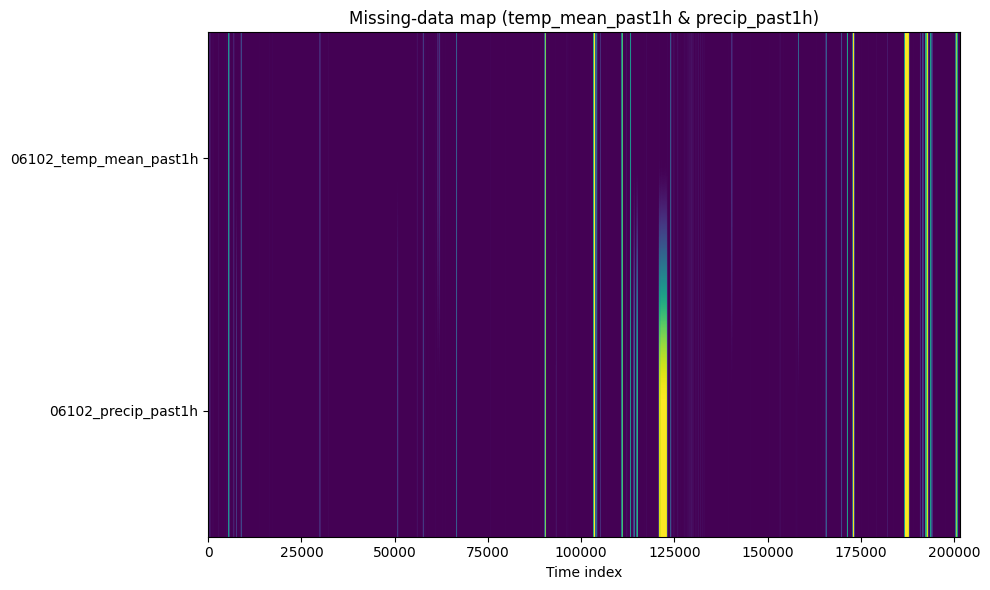

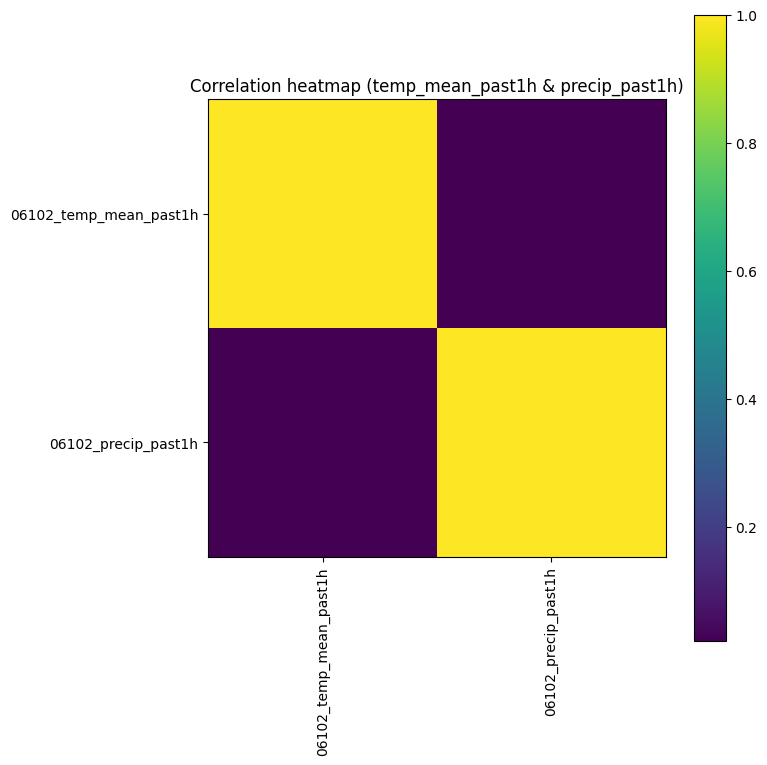

KeyError: "Column 'KarupBro' not found in df_merged!"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1) Missing-value summary (kun temp_mean_past1h og precip_past1h)
# -------------------------------------------------------------

# Udvælg kun de to præcise kolonner
cols_of_interest = ['06102_temp_mean_past1h', '06102_precip_past1h']
df_temp_precip = df_merged[cols_of_interest].copy()

# Missing-value tabel
missing = df_temp_precip.isna().sum().to_frame('missing_count')
missing['missing_pct'] = missing['missing_count'] / len(df_temp_precip) * 100
print("\nMissing-values for temp_mean_past1h og precip_past1h:\n", missing)

# Visualiser missing pattern som heatmap
plt.figure(figsize=(10, 6))
plt.imshow(df_temp_precip.isna().T, aspect='auto')
plt.yticks(range(len(df_temp_precip.columns)), df_temp_precip.columns)
plt.xlabel('Time index')
plt.title('Missing-data map (temp_mean_past1h & precip_past1h)')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2) Correlation matrix (kun temp_mean_past1h og precip_past1h)
# -------------------------------------------------------------
corr = df_temp_precip.corr()

plt.figure(figsize=(8, 8))
plt.imshow(corr, aspect='equal')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.title('Correlation heatmap (temp_mean_past1h & precip_past1h)')
plt.tight_layout()
plt.show()